In [1]:
import os
import pandas as pd
from pycaret.regression import *
import matplotlib.pyplot as plt

import shap
import lime.lime_tabular

In [2]:
INPUT_DIR = os.path.join('..', '..', 'data', 'upsampled')
DATAFRAME_NAME = 'mean_df' # Name of the .csv file without the extension

OUTPUT_ROOT_DIR_WINDOWS = '/mnt/d/EMEWS_ML_Pipelines_Output/regression'
DATAFRAME_SPECIFIC_PATH = os.path.join(OUTPUT_ROOT_DIR_WINDOWS, DATAFRAME_NAME)
BASE_MODEL_PATH = os.path.join(DATAFRAME_SPECIFIC_PATH, 'base_models')
TUNED_MODEL_PATH = os.path.join(DATAFRAME_SPECIFIC_PATH, 'tuned_models')

In [3]:
MODEL_FILE_NAME = 'br'
FINAL_MODEL_PATH = os.path.join(TUNED_MODEL_PATH, MODEL_FILE_NAME)

In [4]:
df = pd.read_csv(os.path.join(INPUT_DIR, f'{DATAFRAME_NAME}.csv'))
df['date'] = pd.to_datetime(df['date'])

In [5]:
fh = 60
split_point = df.shape[0] - fh

train_data = df.iloc[:split_point]
test_data = df.iloc[split_point:]

In [6]:
setup(
    data=train_data,
    target='total_number_of_patients',
    test_data=test_data,
    fold_strategy='timeseries',
    data_split_shuffle=False,
    fold_shuffle=False,
    session_id=123
    );

,Description,Value
0,Session id,123
1,Target,total_number_of_patients
2,Target type,Regression
3,Original data shape,"(618, 21)"
4,Transformed data shape,"(618, 23)"
5,Transformed train set shape,"(558, 23)"
6,Transformed test set shape,"(60, 23)"
7,Numeric features,19
8,Date features,1
9,Preprocess,True


In [7]:
loaded_model = load_model(FINAL_MODEL_PATH)
final_model = loaded_model[-1]
print("Successfully extracted the final model from the pipeline:")
final_model

Transformation Pipeline and Model Successfully Loaded
Successfully extracted the final model from the pipeline:


BayesianRidge(alpha_1=0.024039302552421496, alpha_2=5.0916975850688524e-08,
              lambda_1=4.288230964185691e-05, lambda_2=0.4747181485578233)

In [8]:
X_train_transformed = get_config('X_train_transformed')
X_test_transformed = get_config('X_test_transformed')

## SHAP

In [9]:
background_data = shap.kmeans(X_train_transformed, 100)

In [10]:
shap.initjs()
explainer = shap.KernelExplainer(final_model.predict, background_data)
shap_values = explainer.shap_values(X_test_transformed)

  0%|          | 0/60 [00:00<?, ?it/s]

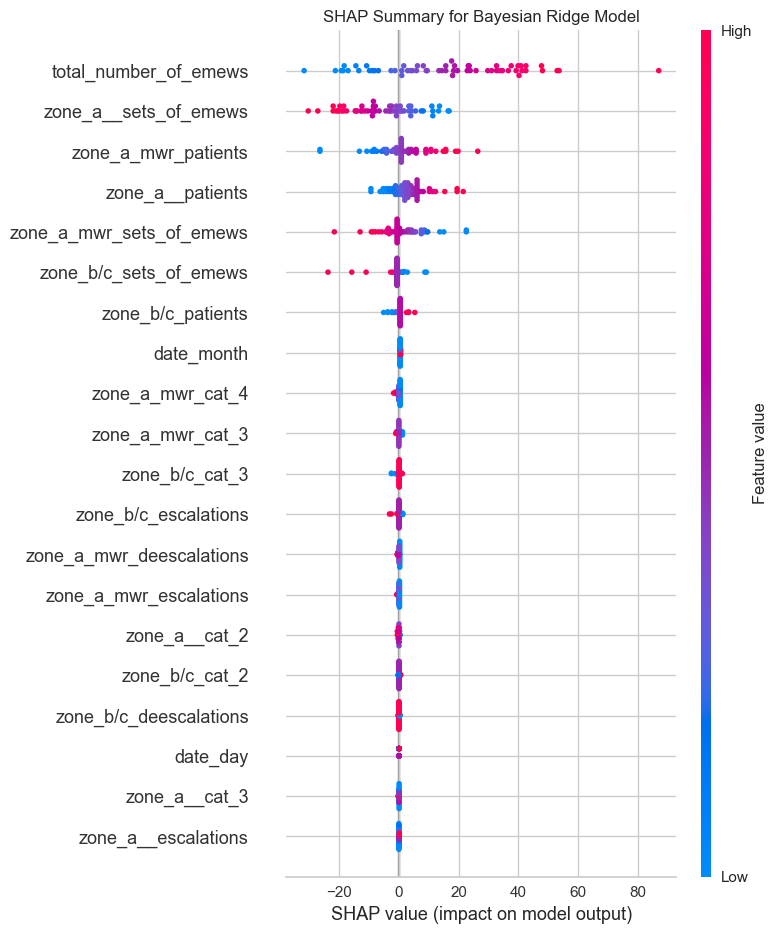

In [11]:
plt.title(f'SHAP Summary for Bayesian Ridge Model')
shap.summary_plot(shap_values, X_test_transformed, show=True)


Generating SHAP force plot for test instance 10...


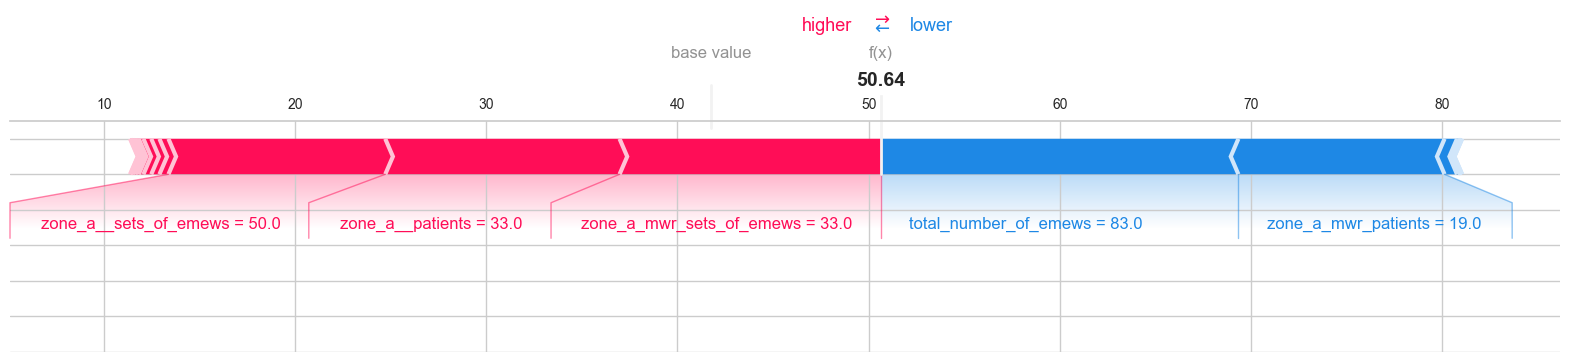

In [12]:
# Force Plot (Local Explanation for a single prediction)
# This plot explains why the model made the prediction it did for one specific data point.
# Red features push the prediction higher, blue features push it lower.
instance_index = 10 # Explain the first data point in the test set
print(f"\nGenerating SHAP force plot for test instance {instance_index}...")
shap.force_plot(explainer.expected_value, shap_values[instance_index,:], X_test_transformed.iloc[instance_index,:], matplotlib=True)


Generating SHAP waterfall plot for test instance 10...


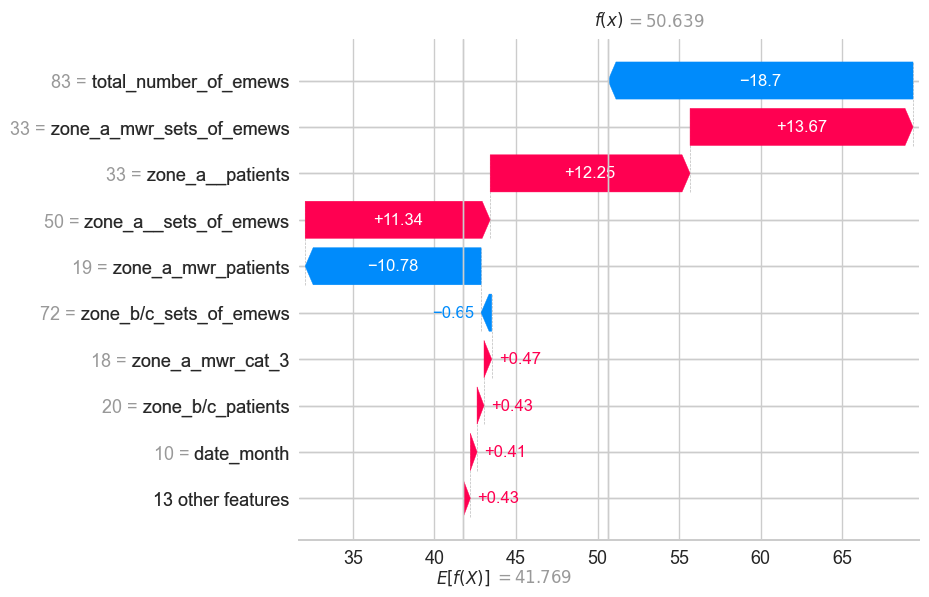

In [13]:
# Waterfall Plot (Detailed Local Explanation)
# A detailed, step-by-step view of the force plot for one instance.
print(f"\nGenerating SHAP waterfall plot for test instance {instance_index}...")
shap.waterfall_plot(shap.Explanation(values=shap_values[instance_index],
                                     base_values=explainer.expected_value,
                                     data=X_test_transformed.iloc[instance_index],
                                     feature_names=X_test_transformed.columns.tolist()),
                    show=True)


Generating SHAP dependence plot for feature: 'zone_a__patients'...


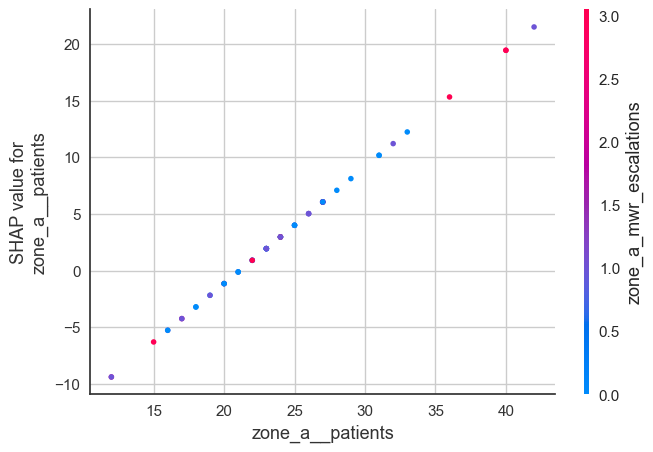

In [14]:
# Dependence Plot (Feature Interaction)
# This plot shows how a single feature's value affects the model's output.
# The vertical dispersion of points can suggest interactions with other features.
# Let's analyze the 'year' feature, which is likely important.
feature_to_plot = 'zone_a__patients'
print(f"\nGenerating SHAP dependence plot for feature: '{feature_to_plot}'...")
shap.dependence_plot(feature_to_plot, shap_values, X_test_transformed, interaction_index="auto", show=True)

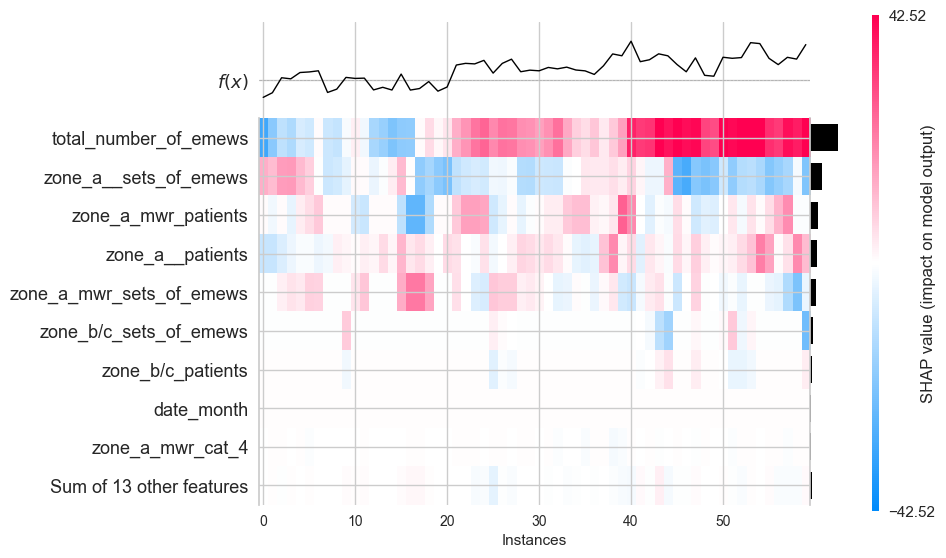

In [15]:
# Heatmap Plot (Global Overview and Interactions)
# This shows the SHAP values for every instance in the test set.
# It can reveal clusters of similar explanations.

expl = shap.Explanation(values=shap_values,
                        data=X_test_transformed,
                        feature_names=X_test_transformed.columns)

shap.plots.heatmap(expl, show=True)

## LIME

In [16]:
lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_transformed.values,
    feature_names=X_train_transformed.columns.tolist(),
    mode='regression'
)

In [17]:
instance_index = 10
instance_to_explain = X_test_transformed.iloc[instance_index].values

In [18]:
explanation = lime_explainer.explain_instance(
    instance_to_explain,
    final_model.predict,
)

In [19]:
explanation.save_to_file("lime_explanation.html")

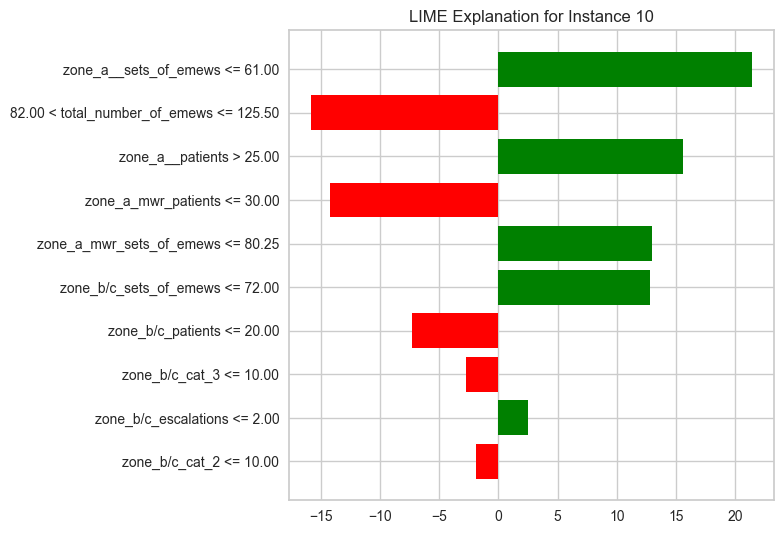

In [20]:
fig = explanation.as_pyplot_figure()
plt.title(f'LIME Explanation for Instance {instance_index}')
plt.tight_layout()
plt.show()
